In [2]:
# Import Necessary Libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score, roc_curve,
    precision_recall_curve, auc, average_precision_score
)
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the Data
data = pd.read_csv('https://classfiles.blob.core.windows.net/files/creditcard.csv')

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

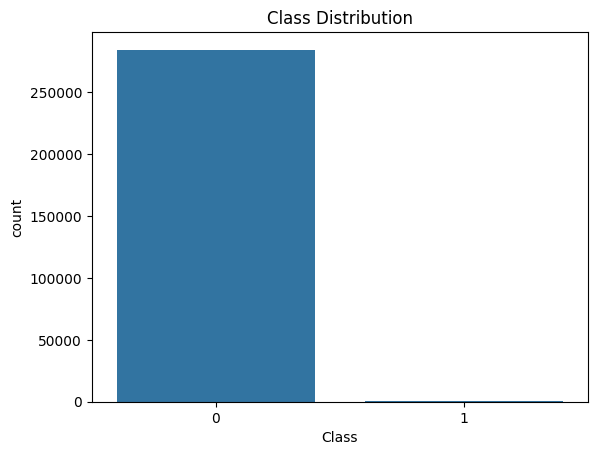

In [4]:
# View first few rows
print(data.head())

# Summary statistics
print(data.describe())

# Class distribution
print(data['Class'].value_counts())

# Plot class distribution
sns.countplot(x='Class', data=data)
plt.title('Class Distribution')
plt.show()

In [5]:
# Separate Features and Target Variable
X = data.drop('Class', axis=1)
y = data['Class']

In [6]:
# Initialize the scaler
scaler = StandardScaler()

# Fit on the 'Amount' and 'Time' features
X[['Time', 'Amount']] = scaler.fit_transform(X[['Time', 'Amount']])

In [7]:
# Split the Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [8]:
# Handle Class Imbalance with SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

# Verify the new class distribution
print(pd.Series(y_resampled).value_counts())

Class
0    227451
1    227451
Name: count, dtype: int64


In [9]:
# Train the Model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_resampled, y_resampled)

RandomForestClassifier(random_state=42)

In [11]:
# Make Predictions
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:, 1]

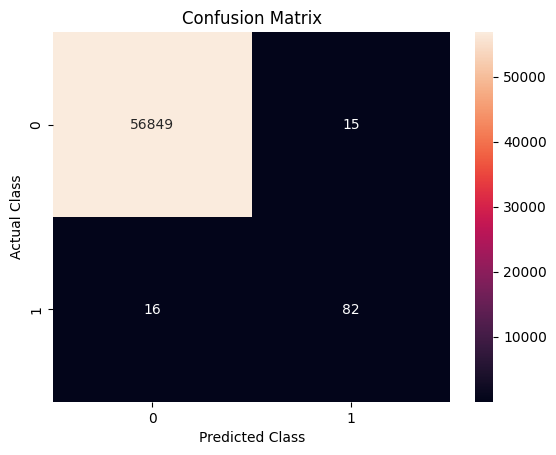

In [12]:
# Evaluate the Model
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

In [13]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.84      0.84        98

    accuracy                           1.00     56962
   macro avg       0.92      0.92      0.92     56962
weighted avg       1.00      1.00      1.00     56962



In [14]:
# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f'ROC AUC Score: {roc_auc:.4f}')

ROC AUC Score: 0.9731


In [15]:
# Precision-Recall Curve and AUC
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)
avg_precision = average_precision_score(y_test, y_pred_prob)
print(f'Precision-Recall AUC: {pr_auc:.4f}')
print(f'Average Precision Score: {avg_precision:.4f}')

Precision-Recall AUC: 0.8766
Average Precision Score: 0.8747


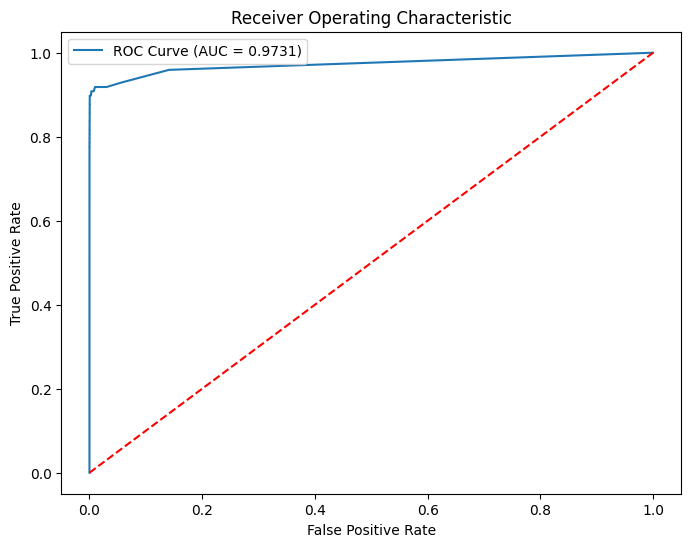

In [16]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'r--')
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

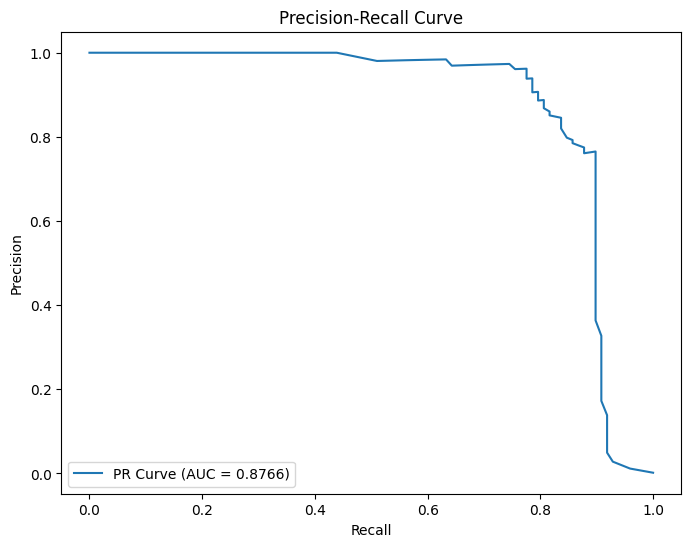

In [17]:
# Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.4f})')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [18]:
# Adjust Class Weights
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_under, y_under = rus.fit_resample(X_train, y_train)

In [19]:
# Cross-Validation with Stratified K-Folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(
    clf, X_resampled, y_resampled, cv=skf, scoring='roc_auc'
)
print(f'Cross-validated ROC AUC scores: {cv_scores}')
print(f'Mean ROC AUC score: {cv_scores.mean():.4f}')

Cross-validated ROC AUC scores: [0.99998718 0.99999999 0.99999984 0.99997558 0.99999967]
Mean ROC AUC score: 1.0000


In [20]:
import joblib

# Save the trained model
joblib.dump(clf, 'fraud_detection_model.pkl')

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']